In [158]:
#基于机器学习的简单交易策略
#导入 pandas
import pandas as pd
#导入绘图库
import matplotlib.pyplot as plt
#导入金融数据获取模块 AKShare
import akshare as ak
import numpy as np
#导入数据集拆分工具
from sklearn.model_selection import train_test_split
#导入KNN分类模型
from sklearn.neighbors import KNeighborsClassifier

In [159]:
#首先我们来定义一个函数，用来获取数据
#传入的三个参数分别是开始日期、结束日期和输出的文件名
def load_stock(start_date, end_date, output_file):
    #首先让程序尝试读取已经下载并保存的文件
    try:
        df = pd.read_pickle(output_file)
        #如果文件已经存在，则输出 “载入股票数据完毕” 
        print("载入股票数据完毕")
    #如果没有找到文件，则重新下载文件
    except FileNotFoundError:
        print("文件未找到，重新下载中")
        #这里指定下载 601816 的交易数据
        df = ak.stock_zh_a_hist(symbol='601857', period='daily', start_date=start_date, end_date=end_date, adjust='hfq')
        #下载成功后保存为 pickle 文件
        df.to_pickle(output_file)
        #通知我们下载完成
        print("下载完成")
    #最后将下载的数据表进行返回
    return df

In [160]:
#下面使用我们定义好的函数来获取交易数据
#获取 3年的数据，从 2021 年 9 月 1 日至 2024 年 9 月 1 日
#保存名为 601816 的 pickle 文件
jhgt = load_stock(start_date='20220301',
                  end_date = '20240228',
                  output_file = '601857.pkl')

载入股票数据完毕


In [161]:
#查看数据的前 5 行
jhgt.head()
#确保日期是索引
#jhgt = jhgt.set_index('日期')

,日期,股票代码,开盘,收盘,最高,最低,成交量,成交额,振幅,涨跌幅,涨跌额,换手率
0,2022-03-01,601857,8.90,8.86,8.90,8.78,2142103,1.220165e+09,1.35,-0.45,-0.04,0.13
1,2022-03-02,601857,9.05,8.97,9.09,8.94,3274136,1.920292e+09,1.69,1.24,0.11,0.20
2,2022-03-03,601857,9.03,9.06,9.15,9.01,3804172,2.260470e+09,1.56,1.00,0.09,0.23
3,2022-03-04,601857,8.98,8.94,9.02,8.88,2445656,1.421203e+09,1.55,-1.32,-0.12,0.15
4,2022-03-07,601857,9.13,9.07,9.16,9.03,3793406,2.261668e+09,1.45,1.45,0.13,0.23


In [162]:
#下面定义一个用于分类的函数，给数据表增加三个字段
#首先是开盘价减去收盘价，命名为 open-close
#其次是最高价减去最低价，命名为 high-low
def classification_tc(df):
    df['open-close'] = df['开盘'] - df['收盘']
    df['high-low'] = df['最高'] - df['最低']

    #添加一个 target 字段，如果次日收盘价高于当日收盘价，则标记为 1 ，否则标记为 -1 
    df['target'] = np.where(df['收盘'].shift(-1) > df['收盘'], 1, -1)

    #去掉有空值的行
    df = df.dropna()

    #将 open-close 和 high-low 作为数据集的特征
    X = df[['open-close','high-low']]

    #将 target 赋值给 y
    y = df['target']

    #将 X 于 y 返回
    return (X, y)

In [163]:
#下面定义一个用于回归的函数
#特征的添加与分类函数类似
#只不过 target 字段改为次日收盘价减去当日收盘价
def regression_tc(df):
    df['open-close'] = df['开盘'] - df['收盘']
    df['high-low'] = df['最高'] - df['最低']
    df['target'] = df['收盘'].shift(-1) - df['收盘']
    df = df.dropna()
    X = df[['open-close', 'high-low']]
    y = df['target']
    #将 X 和 y 返回
    return (X, y)

In [164]:
#使用classification_tc函数生成数据集的特征与目标
X, y = classification_tc(jhgt)

#将数据集拆分为训练集与验证集
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [165]:
#创建一个 KNN 实例， n_neighbors 取 95 
knn_clf = KNeighborsClassifier(n_neighbors= 95)

#使用 KNN 拟合训练集
knn_clf.fit(X_train, y_train)

#输出模型在训练集中的准确率
print("模型在训练集中的准确率：%f"%knn_clf.score(X_train, y_train))
print("模型在验证集中的准确率：%f"%knn_clf.score(X_test, y_test))


模型在训练集中的准确率：0.535284
模型在验证集中的准确率：0.465753


In [166]:
#使用 KNN 模型预测每日股票的涨跌，保存为 Predict_Signal
jhgt['Predict_Signal'] = knn_clf.predict(X)

#在数据集中添加一个字段，用当日收盘价除以前一日收盘价，并取其自然对数
jhgt['Return'] = np.log(jhgt['收盘']/jhgt['收盘'].shift(1))
#查看一下
jhgt.head(50)

,日期,股票代码,开盘,收盘,最高,最低,成交量,成交额,振幅,涨跌幅,涨跌额,换手率,open-close,high-low,target,Predict_Signal,Return
0,2022-03-01,601857,8.90,8.86,8.90,8.78,2142103,1.220165e+09,1.35,-0.45,-0.04,0.13,0.04,0.12,1,-1,NaN
1,2022-03-02,601857,9.05,8.97,9.09,8.94,3274136,1.920292e+09,1.69,1.24,0.11,0.20,0.08,0.15,1,1,0.012339
2,2022-03-03,601857,9.03,9.06,9.15,9.01,3804172,2.260470e+09,1.56,1.00,0.09,0.23,-0.03,0.14,-1,1,0.009983
3,2022-03-04,601857,8.98,8.94,9.02,8.88,2445656,1.421203e+09,1.55,-1.32,-0.12,0.15,0.04,0.14,1,1,-0.013334
4,2022-03-07,601857,9.13,9.07,9.16,9.03,3793406,2.261668e+09,1.45,1.45,0.13,0.23,0.06,0.13,-1,-1,0.014437
5,2022-03-08,601857,9.01,9.03,9.13,8.89,3069428,1.803428e+09,2.65,-0.44,-0.04,0.19,-0.02,0.24,-1,1,-0.004420
6,2022-03-09,601857,9.05,8.87,9.10,8.68,3602256,2.092347e+09,4.65,-1.77,-0.16,0.22,0.18,0.42,-1,1,-0.017878
7,2022-03-10,601857,8.68,8.79,8.81,8.63,2961434,1.656892e+09,2.03,-0.90,-0.08,0.18,-0.11,0.18,-1,-1,-0.009060
8,2022-03-11,601857,8.70,8.71,8.71,8.53,2679131,1.474350e+09,2.05,-0.91,-0.08,0.17,-0.01,0.18,-1,1,-0.009143
9,2022-03-14,601857,8.59,8.59,8.76,8.58,1771882,9.812295e+08,2.07,-1.38,-0.12,0.11,0.00,0.18,-1,1,-0.013873


In [167]:
#定义一个计算累计基准收益的函数
def cum_return(df, split_value):
    #该股票的基本收益为 Return 的总和除以 100 ，这里只计算预测集的结果
    cum_return = df[split_value:]['Return'].cumsum() * 100 
    #将计算结果进行返回
    return cum_return

In [168]:
#定义一个计算使用策略交易的收益
def strategy_return(df, split_value):
    #使用策略交易的收益为，模型 Return 乘以模型预测的涨跌幅
    df['Strategy_Return'] = df['Return'] * df['Predict_Signal'].shift(1)
    #将每日策略交易的收益加和并乘以 100 
    cum_strategy_return = df[split_value:]['Strategy_Return'].cumsum() * 100 
    #将计算结果进行返回
    return cum_strategy_return

In [169]:
#定义一个绘图函数，用来对比基准收益和算法交易的收益
def plot_chart(cum_return, cum_strategy_return, symbol):
    #首先定义画布的尺寸
    plt.figure(figsize = (9, 6))

    #使用折线图绘制基准收益
    plt.plot(cum_return, '--', label = '%s returns' % symbol)
    #使用折线图绘制算法交易收益
    plt.plot(cum_strategy_return, label = 'Strategy Returns')

    #添加图注
    plt.legend()
    #显示图像
    plt.show()
    

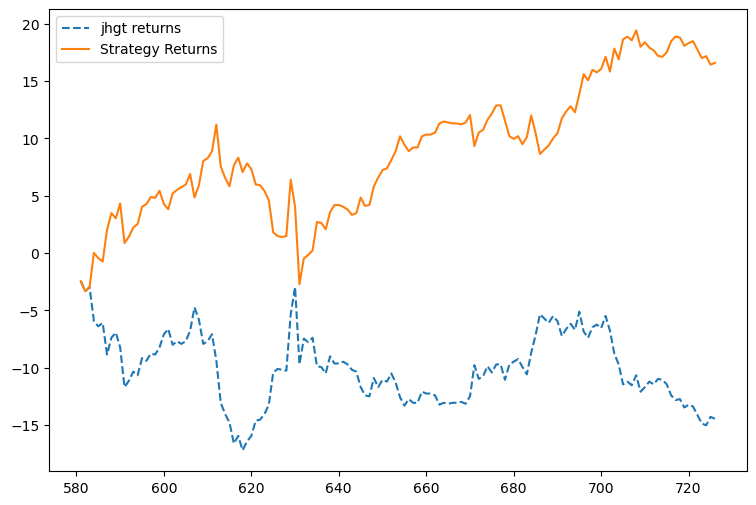

In [170]:
#首先计算基准收益（预测集）
sum_return = cum_return(jhgt, split_value = len(X_train))
#然后计算使用算法交易带来的收益（同样只计算预测集）
sum_strategy_return = strategy_return(jhgt, split_value = len(X_train))
#用图像来进行对比
plot_chart(sum_return, sum_strategy_return, 'jhgt')
